In [1]:
# General libraries
import pandas as pd
import numpy as np

from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
import joblib

# Utils functions
from utils.utils import kfold, read_datasets, plot_pred_expected_results

In [2]:
x_train, x_test, y_train, y_test = read_datasets(
    'x_train_2.csv',
    'x_test_2.csv',
    'y_train_2.csv',
    'y_test_2.csv'
)

In [3]:
folds = kfold()

In [4]:
# Specify range of hyperparameters to tune
hyper_params = {
    'hidden_layer_sizes': [(80,), (100,), (110,), (150,)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.1],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': [0.001, 0.002, 0.005, 0.006],
    'power_t': [0.5, 0.6],
    'max_iter': [200],
    'shuffle': [True],
    'momentum': [0.5, 0.8, 0.9, 1],
    'early_stopping': [False]

}



# Call RandomSearchCV()
model_cv = RandomizedSearchCV(
    estimator = MLPRegressor(),
    param_distributions = hyper_params,
    n_iter=300,
    scoring= 'r2',
    cv = folds,
    verbose = 2,
    return_train_score=True,
    n_jobs = -1,
    refit = True
    )


# Fit the model
best_model = model_cv.fit(x_train, np.ravel(y_train)) 

print(model_cv.best_params_)

Fitting 10 folds for each of 300 candidates, totalling 3000 fits


/Users/renan/Library/Python/3.7/lib/python/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-1.70848035e-02 -4.80338524e-01 -1.53509899e-01  1.05874049e-01
  1.02754356e-01 -2.95273971e-01 -4.31709570e-03  9.69313983e-02
             nan  9.21998349e-02 -3.79652939e-01 -6.84827960e-03
 -3.45689209e-02 -3.42334483e-01 -1.83222959e+00  4.08578106e-02
  1.55104610e-01 -2.88446844e-01  1.05366252e-01  4.96936068e-03
  1.51573915e-01  1.13467533e-01 -5.00294631e-01 -1.63916259e+00
  1.05353894e-01  1.05374480e-01  5.59383390e-02  9.22940899e-02
 -2.86334517e-01  1.12749533e-01 -1.69141495e-01  1.05336220e-01
  2.70546369e-02 -4.70149347e-01  8.62644044e-02  1.35600771e-01
  1.11668298e-01  1.04437962e-01 -3.64278421e-01  9.58785140e-02
 -1.96988109e-03 -2.85421895e-01  1.01770080e-01 -2.28411995e-02
  5.31527631e-02  8.66821475e-02  5.71064390e-02  1.06902642e-01
  1.29323634e-01 -6.92762081e-01  1.09594926e-01 -4.48336131e-0

{'solver': 'sgd', 'shuffle': True, 'power_t': 0.6, 'momentum': 0.9, 'max_iter': 200, 'learning_rate_init': 0.001, 'learning_rate': 'constant', 'hidden_layer_sizes': (110,), 'early_stopping': False, 'alpha': 0.1, 'activation': 'relu'}


/Users/renan/Library/Python/3.7/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [5]:
# Create new model with best_params_ from grid search

mlp_best = best_model.best_estimator_

In [6]:
# Get the results for each split

def get_best_model_cv_split_results(best_model, n_splits=10, set_type='train'):
    results = []
    best_index = best_model.best_index_
    for i in range(0, n_splits):
        current_split = 'split{}_{}_score'.format(i, set_type)
        split_result = best_model.cv_results_[current_split][best_index]
        results.append(split_result)

    return results

print("Train Results: {}".format(get_best_model_cv_split_results(best_model, 10, 'train')))
print("Test Results: {}".format(get_best_model_cv_split_results(best_model, 10, 'test')))

Train Results: [0.26144845664798355, 0.2664841572500063, 0.24612656623638418, 0.255176236711822, 0.2776950080675282, 0.2994247922904326, 0.27109830913825894, 0.27876290821882244, 0.26509174822090165, 0.2664075902570353]
Test Results: [0.24053242903193173, 0.16253123228968192, 0.3340023942236361, 0.22054146207019387, 0.17931008079467403, -0.24334574058890968, 0.16364650296151284, 0.10106139935553982, 0.2068241577905222, 0.2540325383707772]


In [7]:
#Get the mean and std for the train and test

train_mean = sum(get_best_model_cv_split_results(best_model, 10, 'train'))/10
test_mean = sum(get_best_model_cv_split_results(best_model, 10, 'test'))/10

print("Train mean: {}".format(train_mean))
print("Train std: {}".format(np.std(get_best_model_cv_split_results(best_model, 10, 'train'))))

print("-=-=-=-=-=-=-=-=-=-=-=")

print("Validation mean: {}".format(test_mean))
print("Validation std: {}".format(np.std(get_best_model_cv_split_results(best_model, 10, 'test'))))

Train mean: 0.26877157730391754
Train std: 0.013784438166384461
-=-=-=-=-=-=-=-=-=-=-=
Validation mean: 0.161913645629956
Validation std: 0.14764135667840603


In [8]:
y_pred = mlp_best.predict(x_test)
r2 = r2_score(y_test, y_pred)
print("The r2 score on test set: {:.4f}".format(r2))

The r2 score on test set: 0.1529


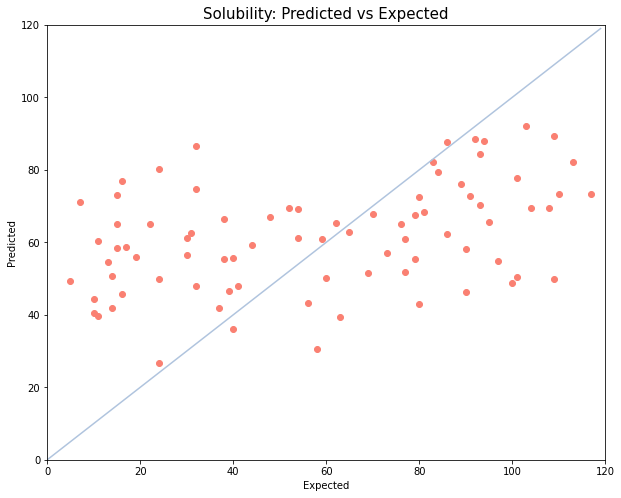

In [9]:
# Plot the R2 predicted and expected results
plot_pred_expected_results(y_test, y_pred)

# Saving trained model

In [10]:
filename = '../models/mlpRegressor_model_high_removed.joblib'
joblib.dump(mlp_best, filename)

['../models/mlpRegressor_model_high_removed.joblib']